# Project9

Leader

m5271046 Yuki Tome

Member

m5271022 Yusuke Matsushima

m5271043 Hiroshi Tatsuta

m5271009 Shota Higa

**Understanding the GAN Algorithm**

Generative Adversarial Networks (GANs) consist of two main components: a generator and a discriminator. The generator creates new data instances, while the discriminator evaluates them for authenticity. The discriminator also checks parts of the real data set to ensure its accuracy. The goal of the generator is to generate passable data to fool the discriminator, and the discriminator's goal is to identify the generator's fakes.

Here are the steps of the GAN algorithm:

Initialize: Initialize the generator and discriminator networks. These can be any kind of neural network, but they are often Convolutional Neural Networks (CNNs).

Generate Fake Data: The generator takes in random numbers and returns data (like an image). This data is called "fake".

Discrimination: The discriminator takes in both real data (actual images from the dataset) and fake data (images produced by the generator). It returns probabilities, a number between 0 and 1, with 1 representing a prediction of authenticity and 0 representing fake.

Calculate Loss: Use the discriminator's probabilities to calculate the loss for both the generator and the discriminator. The generator's loss is calculated using the probabilities for the fake images, while the discriminator's loss is calculated using the probabilities for both the real and fake images.

Backpropagation and Optimization: Use the gradients of the loss to update the generator and discriminator with gradient descent.

Repeat: Repeat steps 2-5 for a certain number of epochs, or until the discriminator and generator loss does not improve significantly.

In [1]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
%matplotlib inline

cuda = torch.cuda.is_available()
if cuda:
    print('cuda available!')

cuda available!


In [2]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc(x)
        return x

In [3]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [4]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 25
sample_num = 16
log_dir = './logs'

In [5]:
# initialize network
G = Generator()
D = Discriminator()
if cuda:
    G.cuda()
    D.cuda()

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

In [6]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 127128463.28it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 113210928.81it/s]


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42673038.91it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19146260.07it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [7]:
def train(D, G, criterion, D_optimizer, G_optimizer, data_loader):
    # 訓練モードへ
    D.train()
    G.train()

    # 本物のラベルは1
    y_real = Variable(torch.ones(batch_size, 1))
    # 偽物のラベルは0
    y_fake = Variable(torch.zeros(batch_size, 1))
    if cuda:
        y_real = y_real.cuda()
        y_fake = y_fake.cuda()

    D_running_loss = 0
    G_running_loss = 0
    for batch_idx, (real_images, _) in enumerate(data_loader):
        # 一番最後、バッチサイズに満たない場合は無視する
        if real_images.size()[0] != batch_size:
            break

        z = torch.rand((batch_size, z_dim))
        if cuda:
            real_images, z = real_images.cuda(), z.cuda()
        real_images, z = Variable(real_images), Variable(z)

        # Discriminatorの更新
        D_optimizer.zero_grad()

        # Discriminatorにとって本物画像の認識結果は1（本物）に近いほどよい
        # E[log(D(x))]
        D_real = D(real_images)
        D_real_loss = criterion(D_real, y_real)

        # DiscriminatorにとってGeneratorが生成した偽物画像の認識結果は0（偽物）に近いほどよい
        # E[log(1 - D(G(z)))]
        # fake_imagesを通じて勾配がGに伝わらないようにdetach()して止める
        fake_images = G(z)
        D_fake = D(fake_images.detach())
        D_fake_loss = criterion(D_fake, y_fake)

        # 2つのlossの和を最小化する
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()  # これでGのパラメータは更新されない！
        #D_running_loss += D_loss.data[0]
        D_running_loss += D_loss.item()

        # Generatorの更新
        G_optimizer.zero_grad()

        # GeneratorにとってGeneratorが生成した画像の認識結果は1（本物）に近いほどよい
        # E[log(D(G(z)))
        fake_images = G(z)
        D_fake = D(fake_images)
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        #G_running_loss += G_loss.data[0]
        G_running_loss += G_loss.item()

    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)

    return D_running_loss, G_running_loss

In [8]:
def generate(epoch, G, log_dir='logs'):
    G.eval()

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    # 生成のもとになる乱数を生成
    sample_z = torch.rand((64, z_dim))
    if cuda:
        sample_z = sample_z.cuda()
    sample_z = Variable(sample_z, volatile=True)

    # Generatorでサンプル生成
    samples = G(sample_z).data.cpu()
    save_image(samples, os.path.join(log_dir, 'epoch_%03d.png' % (epoch)))

In [9]:
history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)

    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)

    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

# 学習履歴を保存
with open(os.path.join(log_dir, 'history.pkl'), 'wb') as f:
    pickle.dump(history, f)

epoch 1, D_loss: 0.8747 G_loss: 1.2675


<ipython-input-8-871cbbde0b15>:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  sample_z = Variable(sample_z, volatile=True)


epoch 2, D_loss: 1.0547 G_loss: 1.1110
epoch 3, D_loss: 1.0766 G_loss: 1.0909
epoch 4, D_loss: 1.0680 G_loss: 1.1142
epoch 5, D_loss: 1.0452 G_loss: 1.1475
epoch 6, D_loss: 1.0206 G_loss: 1.1888
epoch 7, D_loss: 1.0012 G_loss: 1.2253
epoch 8, D_loss: 0.9657 G_loss: 1.2750
epoch 9, D_loss: 0.9470 G_loss: 1.3154
epoch 10, D_loss: 0.9206 G_loss: 1.3568
epoch 11, D_loss: 0.8908 G_loss: 1.4148
epoch 12, D_loss: 0.8628 G_loss: 1.4654
epoch 13, D_loss: 0.8382 G_loss: 1.5053
epoch 14, D_loss: 0.8180 G_loss: 1.5587
epoch 15, D_loss: 0.7809 G_loss: 1.6219
epoch 16, D_loss: 0.7704 G_loss: 1.6687
epoch 17, D_loss: 0.7338 G_loss: 1.7179
epoch 18, D_loss: 0.7258 G_loss: 1.7684
epoch 19, D_loss: 0.6860 G_loss: 1.8361
epoch 20, D_loss: 0.6710 G_loss: 1.8862
epoch 21, D_loss: 0.6558 G_loss: 1.9394
epoch 22, D_loss: 0.6240 G_loss: 2.0033
epoch 23, D_loss: 0.6216 G_loss: 2.0454
epoch 24, D_loss: 0.6163 G_loss: 2.0769
epoch 25, D_loss: 0.5897 G_loss: 2.1243


In [9]:
with open(os.path.join(log_dir, 'history.pkl'), 'rb') as f:
    history = pickle.load(f)

D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

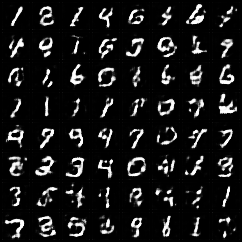

In [12]:
from IPython.display import Image
Image('logs/epoch_001.png')

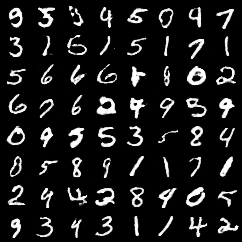

In [13]:
Image('logs/epoch_010.png')

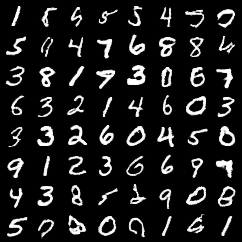

In [14]:
Image('logs/epoch_025.png')